In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

/home/teguh/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/teguh/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/teguh/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/teguh/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/teguh/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarning: n

In [2]:
from numpy.random import multivariate_normal as mvn

In [3]:
from scipy.linalg import expm as expm
from scipy.linalg import logm as logm

### Load Data 

In [4]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

### Standard Linear Regression

In [5]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()
lamda = 0.00001
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+lamda*np.eye(X.shape[1])),X.T),Y)

y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), w)
smse_train = (mean_squared_error(y_pred,y_train))/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), w)
smse_test = (mean_squared_error(y_pred,y_test))/y_var

print smse_train,smse_test

0.07358881422797761 0.0742260930366048


In [6]:
w_standard = w.copy()

### Bayesian Linear Regression 

### Generate simple dataset 

(1000,)
[-2.61893966 -0.33398487  6.09063086  1.42426897 -1.21305057 -5.84004281
 -3.61098609 -0.95814887  3.48855258 -1.58608001 -0.79662788  2.65411318
  3.92253042 -3.32984969  1.52308017 -1.73804878  1.6491582   2.18198919
  1.86608995 -5.86118869  3.94025865]
(1000, 22)


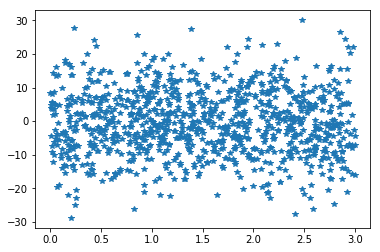

In [121]:
N=1000
X = np.hstack([np.ones((N,1)), 3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
           3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1),
              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1),
              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1)]) 
D = X.shape[1]
w_true = 3*np.random.normal(size=D-1)
Y = np.dot(X[:,:-1],w_true) + 0.2*np.random.normal(size=N)
plt.plot(X[:,1],y,'*')
print Y.shape
print w_true
print X.shape

In [112]:
def grad(params, X,Y):
    alpha = params[0]
    lamda = params[1]
    n = X.shape[0]
    def func(w):
        return (1.*w/alpha + np.dot(X.T, np.dot(X,w) - Y)/lamda)/n    
    return func

def hess(params, X, Y):
    alpha = params[0]
    lamda = params[1]
    n = X.shape[0]
    def func(w):
        return (1./alpha + np.dot(X.T, X)/lamda)/n   
    return func

In [113]:
from math import e

In [114]:
from numpy import log
def f(params, X, Y):
    alpha = params[0]
    lamda = params[1]
    n = X.shape[0]
    def func(w):
        val = 0.5*((n+1)*log(2*np.pi) + n*log(lamda) + log(alpha) + np.dot(w.T,w))
        val += 0.5*np.dot(Y-np.dot(X,w), Y-np.dot(X,w))
        return val
    return func

In [115]:
def ELBO(mu,L,phi,samples):
    d = samples[0].shape[0]
    n = len(samples)
    val = 0.5*d*log(2*np.pi*e) + np.trace(L)
    for sample in samples:
        val -= phi(mu + np.dot(expm(L),sample))/n
        
    return val

In [116]:
def grad_mu(samples, mu, L, params):
    n = len(samples)
    D_in = mu.shape[0]
    delta_mu = np.zeros(D_in)
    grad_w = grad(params, X,y)
    for sample in samples:
        delta_mu += grad_w(mu + np.dot(expm(L),sample))        
    delta_mu /= (-n)
    return delta_mu

#Calculate grad_L using Hessian

def grad_L2(samples, mu, L, params):
    n = len(samples)
    D_in = mu.shape[0]
    delta_L = np.zeros((D_in,D_in))

    for sample in samples:
        delta_L += Hess
        
    delta_L /= n
    delta_L = np.dot(expm(2*L), delta_L)
    delta_L = 0.5*(delta_L + delta_L.T)
    delta_L = -1*delta_L + np.eye(D_in)
    return delta_L

#calculate grad_L using Grad
def grad_L(samples, mu, L, params):
    n = len(samples)   
    D_in = mu.shape[0]
    delta_L = np.zeros((D_in,D_in))
    grad_w = grad(params, X,y)
    for sample in samples:
        delta_L += np.outer(np.dot(expm(L),sample), grad_w(mu + np.dot(expm(L),sample)))
        
    delta_L /= n
    delta_L = 0.5*(delta_L + delta_L.T)
    delta_L = -1*delta_L + np.eye(D_in)
    return delta_L

In [117]:
from scipy.linalg import norm as norm

In [118]:
def compute_GVA( mu_0, L_0, grad_mu_func, grad_L_func, params, num_iter = 200, batch_size = 50, lamda_0 = 0.2, decrease_rate = True):
    lamda = lamda_0
    D_in = mu_0.shape[0]
    mu_cur = mu_0.copy()
    L_cur = L_0.copy()
    grad_mu_prev = 0*mu_cur
    grad_L_prev = 0*L_cur
    phi = f(params,X,Y)
    v = 0.
    cur_elbo = 1e20
    for i in range(num_iter):
        print 'iteration' + str(i)
        samples = np.array([np.random.normal(np.zeros(D_in)) for j in range(batch_size)])
        delta_mu = grad_mu_func(samples, mu_cur, L_cur,params)
        #delta_mu = delta_mu/norm(delta_mu)
        delta_L = grad_L_func(samples, mu_cur, L_cur,params)
        #delta_L = delta_L/norm(delta_L)     
        
        lamda = lamda_0
        next_elbo = 1e21
        count = 0
        while next_elbo > cur_elbo and count < 20:
            mu_next = mu_cur + lamda*delta_mu #+ v*grad_mu_prev
            L_next = L_cur + 0.1*lamda*delta_L #+ v*grad_L_prev
            next_elbo = ELBO(mu_next, L_next, phi, samples)
            lamda = lamda*0.5
            print 'reducing lamda'
            print cur_elbo, next_elbo
            print lamda
            count+=1 
            #grad_mu_prev = mu_next - mu_cur
            #grad_L_prev = L_next-L_cur
        
        cur_elbo = next_elbo
        mu_cur = mu_next
        L_cur = L_next
        
        
        #calculate ELBO
        elbo = ELBO(mu_cur, L_cur, phi, samples)
        print elbo

        if decrease_rate: lamda = lamda_0/(2+i)
        #print mu_cur
    return mu_cur, L_cur

In [122]:
#define parameters
alpha = 10000.
lamda = 1.
params = [alpha,lamda]
hess_w = hess(params, X,y)

D_in = X.shape[1]
D_out = 1

mu_0 = np.random.rand(D_in)
L_0 = np.eye(D_in)

mu = mu_0.copy()
L = L_0.copy()

Hess = hess_w(mu)

In [123]:
mu, L = compute_GVA(mu, L, grad_mu,grad_L2, params,num_iter=500,lamda_0 = 0.01,decrease_rate=True)

iteration0
reducing lamda
1e+20 -550770.2805567189
0.005
-550770.2805567189
iteration1
reducing lamda
-550770.2805567189 -1269945.7540567082
0.005
-1269945.7540567082
iteration2
reducing lamda
-1269945.7540567082 -20546389.46419099
0.005
-20546389.46419099
iteration3
reducing lamda
-20546389.46419099 -8.609580426631069e+36
0.005
-8.609580426631069e+36
iteration4
reducing lamda
-8.609580426631069e+36 nan
0.005
nan
iteration5
nan
iteration6
nan
iteration7
nan
iteration8
nan
iteration9
nan
iteration10
nan
iteration11
nan
iteration12
nan
iteration13
nan
iteration14
nan
iteration15
nan
iteration16
nan
iteration17
nan
iteration18


KeyboardInterrupt: 

In [107]:
print mu, w_true
print np.array(mu[:-1])-np.array(w_true)

Sigma = expm(2*L)
#print Sigma

[0.80249954 0.41633708 0.24037907 0.99169441 0.35701255 0.87658434
 0.65386304 0.83950012 0.55167502 0.11924348 0.49741496 0.5184209
 0.90405195 0.41637844 0.70382833 0.18558827 0.77943662 0.61385413
 0.07009547 0.47793737 0.59866487 0.38493317] [-1.24289335  0.43433872  1.22218887 -0.86539014 -4.97602581 -2.22793405
  1.01608213 -4.36028582 -3.09408803 -5.53903417  0.86243303  4.58507326
 -1.47655011 -0.37735713 -4.56668033 -0.66910569  5.76507994  0.21762217
 -2.73238845 -0.81407748  0.38028969]
[ 2.04539289 -0.01800163 -0.9818098   1.85708455  5.33303836  3.10451839
 -0.3622191   5.19978593  3.64576305  5.65827766 -0.36501808 -4.06665236
  2.38060206  0.79373557  5.27050867  0.85469397 -4.98564331  0.39623196
  2.80248392  1.29201486  0.21837518]


In [ ]:
plt.plot(X[:,1], y,'*')
x = np.arange(0,20,0.1)
X_test = np.array([np.ones(x.shape[0]),x]).T
y_true = np.dot(X_test, w_true)
plt.plot(x, y_true,'-')
plt.figure()

plt.plot(X[:,1], y,'*')

for i in range(10):
    mu_i = mvn(mu, Sigma)
    y_pred = np.dot(X_test,mu_i)
    plt.plot(x, y_pred,'-')

### On Project

In [124]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
y = y_train[:,0]
#define parameters
alpha = 1e10
lamda = 1e1
params = [alpha,lamda]

D_in = X.shape[1]
D_out = 1

mu_0 = 10*np.random.rand(D_in)
L_0 = np.eye(D_in)

mu = mu_0.copy()
L = L_0.copy()

hess_w = hess(params, X,y)
Hess = hess_w(mu)

In [100]:
mu, L = compute_GVA(mu, L, grad_mu,grad_L, params,num_iter=2000,lamda_0 = 0.025,decrease_rate=False,batch_size=100)

iteration0
reducing lamda
1e+20 265794355.82813638
0.0125
265794355.82813638
iteration1
reducing lamda
265794355.82813638 209639100.5966631
0.0125
209639100.5966631
iteration2
reducing lamda
209639100.5966631 173841535.22552186
0.0125
173841535.22552186
iteration3
reducing lamda
173841535.22552186 153497482.23527625
0.0125
153497482.23527625
iteration4
reducing lamda
153497482.23527625 149174455.73275837
0.0125
149174455.73275837
iteration5
reducing lamda
149174455.73275837 123824038.9349743
0.0125
123824038.9349743
iteration6
reducing lamda
123824038.9349743 125764580.6050474
0.0125
reducing lamda
123824038.9349743 132197465.40131234
0.00625
reducing lamda
123824038.9349743 135544586.5641624
0.003125
reducing lamda
123824038.9349743 137251082.46107355
0.0015625
reducing lamda
123824038.9349743 138112598.1527987
0.00078125
reducing lamda
123824038.9349743 138545427.21903604
0.000390625
reducing lamda
123824038.9349743 138762360.09567198
0.0001953125
reducing lamda
123824038.9349743 138

58518832.07939838
iteration23
reducing lamda
58518832.07939838 53147496.379132435
0.0125
53147496.379132435
iteration24
reducing lamda
53147496.379132435 50550857.5852452
0.0125
50550857.5852452
iteration25
reducing lamda
50550857.5852452 54955247.909442164
0.0125
reducing lamda
50550857.5852452 56388030.882972084
0.00625
reducing lamda
50550857.5852452 57170225.42896326
0.003125
reducing lamda
50550857.5852452 57577793.24217768
0.0015625
reducing lamda
50550857.5852452 57785697.27720509
0.00078125
reducing lamda
50550857.5852452 57890679.63984442
0.000390625
reducing lamda
50550857.5852452 57943428.446657725
0.0001953125
reducing lamda
50550857.5852452 57969867.26134462
9.765625e-05
reducing lamda
50550857.5852452 57983102.77212181
4.8828125e-05
reducing lamda
50550857.5852452 57989724.5534456
2.44140625e-05
reducing lamda
50550857.5852452 57993036.45060084
1.220703125e-05
reducing lamda
50550857.5852452 57994692.65080303
6.103515625e-06
reducing lamda
50550857.5852452 57995520.813810

reducing lamda
41435645.33205873 43672384.43535217
2.44140625e-05
reducing lamda
41435645.33205873 43673816.48038714
1.220703125e-05
reducing lamda
41435645.33205873 43674532.544485316
6.103515625e-06
reducing lamda
41435645.33205873 43674890.5869296
3.0517578125e-06
reducing lamda
41435645.33205873 43675069.61075056
1.52587890625e-06
reducing lamda
41435645.33205873 43675159.12331075
7.62939453125e-07
reducing lamda
41435645.33205873 43675203.87975323
3.81469726563e-07
reducing lamda
41435645.33205873 43675226.258015126
1.90734863281e-07
reducing lamda
41435645.33205873 43675237.44715622
9.53674316406e-08
reducing lamda
41435645.33205873 43675243.04172929
4.76837158203e-08
reducing lamda
41435645.33205873 43675245.83901647
2.38418579102e-08
43675245.83901647
iteration39
reducing lamda
43675245.83901647 40951773.28930598
0.0125
40951773.28930598
iteration40
reducing lamda
40951773.28930598 46782736.09751521
0.0125
reducing lamda
40951773.28930598 47527477.54845026
0.00625
reducing lamd

reducing lamda
37115333.19840678 39459835.96486727
2.38418579102e-08
39459835.96486727
iteration53
reducing lamda
39459835.96486727 36262069.72903713
0.0125
36262069.72903713
iteration54
reducing lamda
36262069.72903713 36939183.90893759
0.0125
reducing lamda
36262069.72903713 37339325.41949667
0.00625
reducing lamda
36262069.72903713 37545853.76665271
0.003125
reducing lamda
36262069.72903713 37650736.152041346
0.0015625
reducing lamda
36262069.72903713 37703582.37749458
0.00078125
reducing lamda
36262069.72903713 37730106.80858003
0.000390625
reducing lamda
36262069.72903713 37743394.3612457
0.0001953125
reducing lamda
36262069.72903713 37750044.47280169
9.765625e-05
reducing lamda
36262069.72903713 37753371.11250331
4.8828125e-05
reducing lamda
36262069.72903713 37755034.82834979
2.44140625e-05
reducing lamda
36262069.72903713 37755866.785273746
1.220703125e-05
reducing lamda
36262069.72903713 37756282.788486175
6.103515625e-06
reducing lamda
36262069.72903713 37756490.79628002
3.05

reducing lamda
29215120.31827697 33610787.734104216
9.765625e-05
reducing lamda
29215120.31827697 33613793.12232734
4.8828125e-05
reducing lamda
29215120.31827697 33615297.062521145
2.44140625e-05
reducing lamda
29215120.31827697 33616049.34414018
1.220703125e-05
reducing lamda
29215120.31827697 33616425.56283047
6.103515625e-06
reducing lamda
29215120.31827697 33616613.69164583
3.0517578125e-06
reducing lamda
29215120.31827697 33616707.76092106
1.52587890625e-06
reducing lamda
29215120.31827697 33616754.79677556
7.62939453125e-07
reducing lamda
29215120.31827697 33616778.31500703
3.81469726563e-07
reducing lamda
29215120.31827697 33616790.074198805
1.90734863281e-07
reducing lamda
29215120.31827697 33616795.95381373
9.53674316406e-08
reducing lamda
29215120.31827697 33616798.89362596
4.76837158203e-08
reducing lamda
29215120.31827697 33616800.363533236
2.38418579102e-08
33616800.363533236
iteration70
reducing lamda
33616800.363533236 33136228.576637883
0.0125
33136228.576637883
iterat

KeyboardInterrupt: 

In [101]:
mu

array([0.2176136 , 5.9988274 , 5.23107781, 8.30617922, 6.05670391,
       7.32275021, 7.33771332, 5.33587302, 3.40592123, 5.07833471,
       0.44979202, 3.3849827 , 6.30649906, 8.11748257, 5.72060224,
       6.44336494, 1.45780048, 9.18947239, 0.97424277, 8.75498927,
       7.77051099, 4.89668507])

In [720]:
for i in range(1000):
    mu = mu - 0.1*np.dot(np.linalg.inv(hess_w(mu)),grad_w(mu))
    #mu = mu - 0.01*grad_w(mu)
    print mu

[ 4.93226966e+00  3.23086008e+00  1.17066038e+00  1.56952031e-02
 -7.91158225e-01  8.00360341e-01  1.62114568e+00 -4.87867532e-02
  3.96727201e-01  9.00760213e-02  4.52404736e-01 -3.03183419e-03
  7.43696259e-01  8.86627134e-01  5.11650975e-01  8.71101864e-01
  6.59009578e-01  5.83728303e-01  6.29353696e-01  8.04238976e-01
  2.00823029e-01  7.25749846e-02]
[ 8.65431077  5.60918569  1.82332601 -0.75291755 -2.00460221  1.27323492
  2.1984359  -0.5970998   0.38761171  0.09575428  0.37604879 -0.06124686
  0.67185335  0.85632341  0.42896703  1.03749692  0.56315744  0.50054286
  0.63234786  0.69591793  0.18938188  0.06604973]
[12.00414759  7.74967882  2.4107251  -1.44466894 -3.09670169  1.69882205
  2.71799707 -1.09058145  0.37940777  0.10086472  0.30732844 -0.11364038
  0.60719474  0.82905006  0.35455147  1.18725247  0.47689051  0.42567597
  0.63504262  0.59842898  0.17908485  0.06017699]
[15.01900056  9.67612272  2.9393843  -2.06724512 -4.07959112  2.08185049
  3.1856021  -1.53471485  0.37

[ 4.07326314e+01  2.61067437e+01  7.44831289e+00 -7.37718380e+00
 -1.24626356e+01  5.34869592e+00  7.17379741e+00 -5.32271673e+00
  3.09050098e-01  1.44692570e-01 -2.82023270e-01 -5.62971776e-01
  5.26770501e-02  5.95151177e-01 -2.83642721e-01  2.47156936e+00
 -2.62942313e-01 -2.16389112e-01  6.58153109e-01 -2.37644808e-01
  9.07765914e-02  9.81199173e-03]
[ 4.08746346e+01  2.61974818e+01  7.47321344e+00 -7.40650784e+00
 -1.25089308e+01  5.36673707e+00  7.19582217e+00 -5.34363587e+00
  3.08702325e-01  1.44909212e-01 -2.84936404e-01 -5.65192797e-01
  4.99361014e-02  5.93995024e-01 -2.86797280e-01  2.47791767e+00
 -2.66599268e-01 -2.19562805e-01  6.58267344e-01 -2.41777477e-01
  9.03400882e-02  9.56304093e-03]
[ 4.10024375e+01  2.62791461e+01  7.49562393e+00 -7.43289946e+00
 -1.25505965e+01  5.38297411e+00  7.21564446e+00 -5.36246309e+00
  3.08389328e-01  1.45104190e-01 -2.87558224e-01 -5.67191716e-01
  4.74692478e-02  5.92954487e-01 -2.89636383e-01  2.48363115e+00
 -2.69890528e-01 -2.22

[ 4.20984861e+01  2.69795065e+01  7.68781837e+00 -7.65923616e+00
 -1.29079249e+01  5.52222438e+00  7.38564203e+00 -5.52392673e+00
  3.05705043e-01  1.46776354e-01 -3.10043182e-01 -5.84334616e-01
  2.63133034e-02  5.84030737e-01 -3.13984772e-01  2.53263047e+00
 -2.98116664e-01 -2.46915219e-01  6.59251876e-01 -2.77394802e-01
  8.65780935e-02  7.41746626e-03]
[ 4.21039038e+01  2.69829684e+01  7.68876838e+00 -7.66035493e+00
 -1.29096912e+01  5.52291269e+00  7.38648232e+00 -5.52472483e+00
  3.05691774e-01  1.46784619e-01 -3.10154323e-01 -5.84419353e-01
  2.62087307e-02  5.83986627e-01 -3.14105125e-01  2.53287267e+00
 -2.98256184e-01 -2.47036302e-01  6.59256235e-01 -2.77552471e-01
  8.65614400e-02  7.40796832e-03]
[ 4.21087797e+01  2.69860840e+01  7.68962338e+00 -7.66136182e+00
 -1.29112808e+01  5.52353217e+00  7.38723858e+00 -5.52544313e+00
  3.05679833e-01  1.46792058e-01 -3.10254351e-01 -5.84495615e-01
  2.61146154e-02  5.83946928e-01 -3.14213442e-01  2.53309065e+00
 -2.98381752e-01 -2.47

[ 4.21509889e+01  2.70130552e+01  7.69702487e+00 -7.67007809e+00
 -1.29250416e+01  5.52889475e+00  7.39378524e+00 -5.53166111e+00
  3.05576460e-01  1.46856455e-01 -3.11120254e-01 -5.85155794e-01
  2.52998940e-02  5.83603270e-01 -3.15151107e-01  2.53497763e+00
 -2.99468751e-01 -2.48088629e-01  6.59294113e-01 -2.78922774e-01
  8.64167050e-02  7.32542215e-03]
[ 4.21511563e+01  2.70131622e+01  7.69705423e+00 -7.67011266e+00
 -1.29250962e+01  5.52891602e+00  7.39381120e+00 -5.53168578e+00
  3.05576050e-01  1.46856711e-01 -3.11123689e-01 -5.85158413e-01
  2.52966624e-02  5.83601907e-01 -3.15154826e-01  2.53498512e+00
 -2.99473062e-01 -2.48092371e-01  6.59294248e-01 -2.78927647e-01
  8.64161903e-02  7.32512863e-03]
[ 4.21513070e+01  2.70132585e+01  7.69708065e+00 -7.67014378e+00
 -1.29251453e+01  5.52893516e+00  7.39383457e+00 -5.53170797e+00
  3.05575681e-01  1.46856941e-01 -3.11126780e-01 -5.85160769e-01
  2.52937540e-02  5.83600680e-01 -3.15158173e-01  2.53499185e+00
 -2.99476943e-01 -2.48

[ 4.21526114e+01  2.70140920e+01  7.69730938e+00 -7.67041314e+00
 -1.29255706e+01  5.52910089e+00  7.39403689e+00 -5.53190013e+00
  3.05572487e-01  1.46858931e-01 -3.11153539e-01 -5.85181171e-01
  2.52685766e-02  5.83590060e-01 -3.15187150e-01  2.53505017e+00
 -2.99510534e-01 -2.48124891e-01  6.59295418e-01 -2.78969994e-01
  8.64117175e-02  7.32257771e-03]
[ 4.21526165e+01  2.70140953e+01  7.69731028e+00 -7.67041421e+00
 -1.29255723e+01  5.52910154e+00  7.39403769e+00 -5.53190089e+00
  3.05572474e-01  1.46858939e-01 -3.11153645e-01 -5.85181252e-01
  2.52684767e-02  5.83590018e-01 -3.15187265e-01  2.53505040e+00
 -2.99510668e-01 -2.48125007e-01  6.59295422e-01 -2.78970144e-01
  8.64117016e-02  7.32256864e-03]
[ 4.21526212e+01  2.70140982e+01  7.69731110e+00 -7.67041517e+00
 -1.29255738e+01  5.52910213e+00  7.39403841e+00 -5.53190157e+00
  3.05572463e-01  1.46858946e-01 -3.11153741e-01 -5.85181325e-01
  2.52683868e-02  5.83589980e-01 -3.15187368e-01  2.53505061e+00
 -2.99510788e-01 -2.48

[ 4.21526611e+01  2.70141238e+01  7.69731810e+00 -7.67042342e+00
 -1.29255868e+01  5.52910721e+00  7.39404461e+00 -5.53190746e+00
  3.05572365e-01  1.46859007e-01 -3.11154560e-01 -5.85181949e-01
  2.52676160e-02  5.83589655e-01 -3.15188256e-01  2.53505239e+00
 -2.99511816e-01 -2.48126004e-01  6.59295458e-01 -2.78971442e-01
  8.64115646e-02  7.32249047e-03]
[ 4.21526613e+01  2.70141239e+01  7.69731814e+00 -7.67042346e+00
 -1.29255869e+01  5.52910723e+00  7.39404464e+00 -5.53190749e+00
  3.05572364e-01  1.46859007e-01 -3.11154564e-01 -5.85181952e-01
  2.52676122e-02  5.83589653e-01 -3.15188260e-01  2.53505240e+00
 -2.99511821e-01 -2.48126008e-01  6.59295458e-01 -2.78971448e-01
  8.64115640e-02  7.32249012e-03]
[ 4.21526615e+01  2.70141240e+01  7.69731817e+00 -7.67042349e+00
 -1.29255869e+01  5.52910726e+00  7.39404466e+00 -5.53190751e+00
  3.05572364e-01  1.46859007e-01 -3.11154568e-01 -5.85181955e-01
  2.52676087e-02  5.83589652e-01 -3.15188264e-01  2.53505241e+00
 -2.99511826e-01 -2.48

[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042380e+00
 -1.29255874e+01  5.52910744e+00  7.39404489e+00 -5.53190773e+00
  3.05572360e-01  1.46859009e-01 -3.11154598e-01 -5.85181978e-01
  2.52675801e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48126045e-01  6.59295460e-01 -2.78971496e-01
  8.64115589e-02  7.32248721e-03]
[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042380e+00
 -1.29255874e+01  5.52910745e+00  7.39404490e+00 -5.53190773e+00
  3.05572360e-01  1.46859009e-01 -3.11154599e-01 -5.85181979e-01
  2.52675799e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48126045e-01  6.59295460e-01 -2.78971496e-01
  8.64115588e-02  7.32248719e-03]
[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042381e+00
 -1.29255874e+01  5.52910745e+00  7.39404490e+00 -5.53190773e+00
  3.05572360e-01  1.46859010e-01 -3.11154599e-01 -5.85181979e-01
  2.52675797e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675780e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.5

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.5

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

In [719]:
hess_w = hess(params, X, y)
grad_w = grad(params,X,y)
hess_w(mu).shape

(22, 22)

[ 5.5823736   5.17844121 -0.0612802   0.86193841  5.0922824  -0.43700402
  3.44670951  0.87611217  0.58911404  0.81823266 -0.23394826 -0.31954028
  0.34877948  0.99516751 -0.28859336  2.17372331 -0.44041433 -0.08252259
  0.83541969 -0.33750117  0.02765913  0.19073364] [[ 4.21526690e+01]
 [ 2.70141224e+01]
 [ 7.69731909e+00]
 [-7.67042577e+00]
 [-1.29255909e+01]
 [ 5.52910732e+00]
 [ 7.39404566e+00]
 [-5.53190982e+00]
 [ 3.05572363e-01]
 [ 1.46859020e-01]
 [-3.11154562e-01]
 [-5.85181994e-01]
 [ 2.52675725e-02]
 [ 5.83589600e-01]
 [-3.15188315e-01]
 [ 2.53505246e+00]
 [-2.99511857e-01]
 [-2.48126062e-01]
 [ 6.59295434e-01]
 [-2.78971499e-01]
 [ 8.64115669e-02]
 [ 7.32246785e-03]]


In [784]:
hess_mu = (hess_w(mu))
print np.linalg.eig(hess_mu)[0]

[3591.1815 1535.3548  377.3886  297.7895  151.2884   81.3715   62.7859
   39.2799   24.5734   19.6637    2.6003    2.1622    1.4274    1.2823
    0.5714    0.4645    0.3962    0.2219    0.0087    0.0251    0.0881
    0.1054]


In [102]:
y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), mu)
smse_train = (mean_squared_error(y_pred,y_train))/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), mu)
smse_test = (mean_squared_error(y_pred,y_test))/y_var

print smse_train,smse_test

29.47710961002594 29.714956436576635


In [834]:
mu

array([ 1.5948,  0.645 ,  0.5435,  0.7749,  1.212 ,  1.0151,  0.8982,
        0.7802,  0.8684,  0.7856,  0.8063,  0.8132,  0.1865,  0.0276,
        0.1659,  1.788 , -0.1026,  0.2959,  0.5705, -0.0948,  0.1401,
        0.1794])

In [836]:
w_standard

array([[ 42.1527],
       [ 27.0141],
       [  7.6973],
       [ -7.6704],
       [-12.9256],
       [  5.5291],
       [  7.394 ],
       [ -5.5319],
       [  0.3056],
       [  0.1469],
       [ -0.3112],
       [ -0.5852],
       [  0.0253],
       [  0.5836],
       [ -0.3152],
       [  2.5351],
       [ -0.2995],
       [ -0.2481],
       [  0.6593],
       [ -0.279 ],
       [  0.0864],
       [  0.0073]])

In [125]:
y_var

418.7982691237813

In [138]:
32/y_var

0.07640910280491628

In [139]:
31.6/y_var

0.07545398901985483